# FINAL PROJECT CIS 432
## Members: Miguel Novo Villar, Lisa Pink, Dikshant Tiwari, Thomas Durkin & Maheen Ansari
## 28 April 2022

## Import Modules

In [304]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.impute import MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn import tree, linear_model, neighbors
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

import random
random.seed(10)

# ETL
<a class='anchor' id='etl'></a>

In [133]:
df = pd.read_csv("heloc_dataset_v1.csv")

In [134]:
# df.info()

In [135]:
# df.hist(figsize=(15,15))

# Descriptive Analysis
<a class='anchor' id='descriptive-analysis'></a>

## Descriptive Statistics
<a class='anchor' id='descriptive-statistics'></a>

In [136]:
# df.describe()

Correlation Matrix
<a class='anchor' id='corr-matrix'></a>

Text(0.5, 1.0, 'Correlation Matrix')

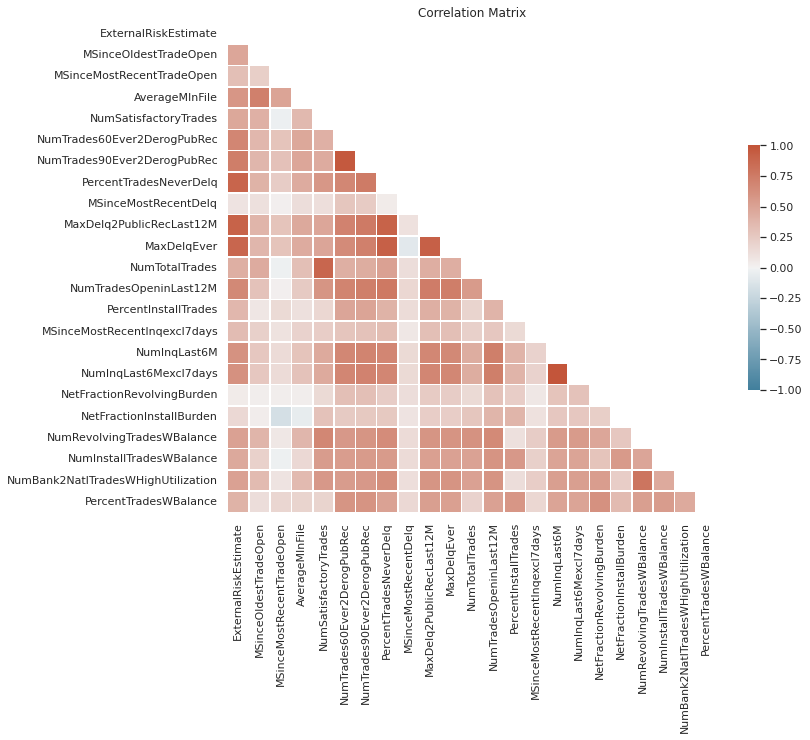

In [137]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix')

In [138]:
#separate variables
X = df.iloc[:,1:24] #independent
Y = df.iloc[:,[0]].replace(to_replace=['Good', 'Bad'], value=[0, 1]).squeeze() #dependent

In [139]:
#Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Data & Feature engineering

In [140]:
#Merge again
df_train = X_train.join(Y_train)
df_test = X_test.join(Y_test)

#drop from merge (-9)
df_train = df_train.drop((df_train.loc[df['ExternalRiskEstimate']==-9]).index)
df_test = df_test.drop((df_test.loc[df['ExternalRiskEstimate']==-9]).index)

#Split XY in train
X_train = df_train.iloc[:,0:23]
Y_train = df_train.iloc[:,23]

#Split XY in test
X_test = df_test.iloc[:,0:23]
Y_test = df_test.iloc[:,23]


In [141]:
#Count missing (How many bad values do we have)
df_count_missing = pd.concat([(X_train==-7).sum(), (X_train==-8).sum(), (X_train==-9).sum()], axis=1)
df_count_missing.columns = [-7,-8,-9]
df_count_missing

,-7,-8,-9
ExternalRiskEstimate,0,0,0
MSinceOldestTradeOpen,0,192,0
MSinceMostRecentTradeOpen,0,0,0
AverageMInFile,0,0,0
NumSatisfactoryTrades,0,0,0
NumTrades60Ever2DerogPubRec,0,0,0
NumTrades90Ever2DerogPubRec,0,0,0
PercentTradesNeverDelq,0,0,0
MSinceMostRecentDelq,3739,127,0
MaxDelq2PublicRecLast12M,0,0,0


In [142]:
#Pipelines
do_nothing_imputer = ColumnTransformer([("Imputer -7 to mean", SimpleImputer(missing_values=-7, strategy='mean'), [])], remainder='passthrough')

feature_expansion = FeatureUnion([("do nothing", do_nothing_imputer),
                                  ("add features for -7", MissingIndicator(missing_values=-7, features='missing-only')),
                                  ("add features for -8", MissingIndicator(missing_values=-8, features='missing-only'))])
 
pipe_example = Pipeline([("expand features", feature_expansion), 
                 ("replace -7 with -8", SimpleImputer(missing_values=-7, strategy='constant', fill_value=-8)),
                 ("replace -8 with mean", SimpleImputer(missing_values=-8, strategy='mean'))])

In [143]:
#Creating pipeline with desired transformations
pipeline = Pipeline([('expand features', feature_expansion),('replace -7 with -8', SimpleImputer(missing_values = -7, strategy ='constant', fill_value = -8 )),
                    ('replace -8 with mean', SimpleImputer(missing_values = -8, strategy = 'mean'))])

#storing the result from pipeline on training set X to arr_X_train_t
arr_X_train_t = pipeline.fit(X_train).transform(X_train)


In [144]:
#Adding missing indicators for -7 and -8
minus_7 = MissingIndicator(missing_values=-7, features='missing-only').fit(X_train)
minus_8 = MissingIndicator(missing_values=-8, features='missing-only').fit(X_train)

#getting column names for columns with -7 as missing values
colnames_minus_7 = X_train.columns.values[minus_7.features_].tolist() 
colnames_minus_7 = list(map(lambda s:str(s)+'=-7',colnames_minus_7))

#getting column names for columns with -8 as missing values
colnames_minus_8 = X_train.columns.values[minus_8.features_].tolist() 
colnames_minus_8 = list(map(lambda s:str(s)+'=-8',colnames_minus_8))

#combining all column names to form a single list
column_names = X_train.columns.values.tolist() + colnames_minus_7 + colnames_minus_8

In [145]:
X_train_t = pd.DataFrame(arr_X_train_t, columns = column_names)
X_train_t

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days=-7,MSinceOldestTradeOpen=-8,MSinceMostRecentDelq=-8,MSinceMostRecentInqexcl7days=-8,NetFractionRevolvingBurden=-8,NetFractionInstallBurden=-8,NumRevolvingTradesWBalance=-8,NumInstallTradesWBalance=-8,NumBank2NatlTradesWHighUtilization=-8,PercentTradesWBalance=-8
0,64.0,174.0,16.0,63.0,17.0,1.0,1.0,89.0,1.000000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64.0,240.0,5.0,93.0,20.0,2.0,2.0,91.0,7.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,68.0,156.0,6.0,46.0,10.0,1.0,0.0,91.0,21.760339,6.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62.0,193.0,3.0,78.0,15.0,2.0,2.0,100.0,21.760339,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,72.0,275.0,12.0,80.0,4.0,0.0,0.0,80.0,9.000000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7875,85.0,278.0,13.0,104.0,23.0,0.0,0.0,100.0,21.760339,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7876,73.0,197.0,5.0,79.0,40.0,0.0,0.0,100.0,21.760339,7.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7877,57.0,155.0,0.0,42.0,32.0,0.0,0.0,97.0,0.000000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7878,83.0,217.0,1.0,73.0,34.0,0.0,0.0,100.0,21.760339,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
X_train_t_tr, X_train_t_val, Y_train_t_tr, Y_train_t_val = train_test_split(X_train_t, Y_train, test_size=0.25)

## MODELS

Tree, Linear_model, K-Neighbors    

In [281]:
clf_tree    = tree.DecisionTreeClassifier().fit(X_train_t_tr, Y_train_t_tr)
clf_log_reg = linear_model.LogisticRegression(max_iter=10000).fit(X_train_t_tr, Y_train_t_tr) 
clf_knn     = neighbors.KNeighborsClassifier().fit(X_train_t_tr, Y_train_t_tr)

In [282]:
print('Decision tree accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_tree.predict(X_train_t_val)))
print('Logistic regression accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))
print('KNN accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_knn.predict(X_train_t_val)))

Decision tree accuracy: 0.632
Logistic regression accuracy: 0.736
KNN accuracy: 0.672


Cross Validation - Tree, Linear_model, K-Neighbors

In [283]:
cv_results_tree = cross_validate(tree.DecisionTreeClassifier(), X_train_t, Y_train, cv=5, return_estimator=True)
cv_results_log_reg = cross_validate(linear_model.LogisticRegression(max_iter=10000), X_train_t, Y_train, cv=5, return_estimator=True)
cv_results_knn = cross_validate(neighbors.KNeighborsClassifier(), X_train_t, Y_train, cv=5, return_estimator=True)

In [284]:
print('Classification tree - CV accuracy score %.3f'%cv_results_tree['test_score'].mean()) # this is their average value
print('Logistic regresion - CV accuracy score %.3f'%cv_results_log_reg['test_score'].mean()) # this is their average value
print('KNN - CV accuracy score %.3f'%cv_results_knn['test_score'].mean()) # this is their average value

Classification tree - CV accuracy score 0.633
Logistic regresion - CV accuracy score 0.740
KNN - CV accuracy score 0.675


Validation Accuracy - Tree, Linear_model, K-Neighbors

In [285]:
print('Classification tree - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_tree.predict(X_train_t_val)))
print('Logistic regresion - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))
print('KNN - validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_knn.predict(X_train_t_val)))

Classification tree - validation accuracy score: 0.632
Logistic regresion - validation accuracy score: 0.736
KNN - validation accuracy score: 0.672


Perform grid search - Logistic Regression

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20)
    }
]
clf = GridSearchCV(linear_model.LogisticRegression(), param_grid = param_grid, cv = 5, n_jobs=-1, scoring = "accuracy")
clf.fit(X_train_t_tr, Y_train_t_tr)

In [292]:
clf.best_params_

{'C': 10000.0, 'penalty': 'l2'}

In [294]:
#Use best params - logistic Regression
clf_log_reg = linear_model.LogisticRegression(max_iter=10000, penalty="l2").fit(X_train_t_tr, Y_train_t_tr) 
print('Logistic regression accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))

Logistic regression accuracy: 0.736


In [299]:
#Cross validate results - logistic Regression
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf_log_reg, X_train_t_tr, Y_train_t_tr, cv=5)

In [312]:
print("%0.2f accuracy of logistic regression with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.74 accuracy of logistic regression with a standard deviation of 0.02


In [313]:
print('logistic regression validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))

logistic regression validation accuracy score: 0.736


Gradient Boosting

In [317]:
#Perfom model
clf_grad = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1).fit(X_train_t_tr, Y_train_t_tr) 
clf_grad.score(X_train_t_tr, Y_train_t_tr)

0.7561759729272419

In [324]:
#Grid Search Gradient Boosting
parameters = {
    "learning_rate": [0.01, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 1),
    "min_samples_leaf": np.linspace(0.1, 0.5, 1),
    "max_depth":[3,5,8],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.8,1.0]
    }
#passing the scoring function in the GridSearchCV
clf_grad_boos = GridSearchCV(GradientBoostingClassifier(), parameters,scoring="accuracy",refit=False,cv=3, n_jobs=-1)

clf_grad_boos.fit(X_train_t_tr, Y_train_t_tr)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.01, 0.1, 0.15, 0.2],
                         'max_depth': [3, 5, 8], 'max_features': ['sqrt'],
                         'min_samples_leaf': array([0.1]),
                         'min_samples_split': array([0.1]),
                         'subsample': [0.5, 0.8, 1.0]},
             refit=False, scoring='accuracy')

In [328]:
clf_grad_boos.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.15,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'subsample': 0.8}

In [318]:
scores1 = cross_val_score(clf_grad, X_train_t_tr, Y_train_t_tr, cv=5)
print("%0.2f Gradient boosting accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))

0.74 Gradient boosting accuracy with a standard deviation of 0.01


In [320]:
print('Gradient Boosting- validation accuracy score: %.3f'%accuracy_score(Y_train_t_val, clf_grad.predict(X_train_t_val)))

Gradient Boosting- validation accuracy score: 0.733
